In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import sys
sys.path.append('..')
from PIL import Image
from tqdm import trange
#from data_utils import get_nth_episode_info
from IPython.display import clear_output
from sapien.core import Pose
from mani_skill2.envs.pick_and_place.base_env import StationaryManipulationEnv
from mani_skill2.utils.registration import register_env
import gymnasium as gym
import sapien.core as sapien
from mani_skill2 import ASSET_DIR
from pathlib import Path
from typing import Dict, List
from mani_skill2 import format_path
from mani_skill2.utils.io_utils import load_json
import numpy as np
from sapien.core import Pose
import matplotlib.pyplot as plt
from mani_skill2.agents.base_agent import BaseAgent
import os

# Register ManiSkill2 environments in gym
import mani_skill2.envs
from mani_skill2 import ASSET_DIR
from mani_skill2.utils.sapien_utils import look_at
from mani_skill2.utils.registration import register_env
from mani_skill2.envs.pick_and_place.pick_cube import PickCubeEnv
from mani_skill2.utils.sapien_utils import hex2rgba
from mani_skill2.sensors.camera import CameraConfig
from transforms3d.euler import euler2quat, quat2euler
from mani_skill2.utils.sapien_utils import vectorize_pose
from mani_skill2.agents.base_controller import BaseController
from IPython.display import Video
import shutil
import random
from plot_utils import *
import math

In [3]:
#!wget https://dl.fbaipublicfiles.com/habitat/ReplicaCAD/hab2_bench_assets.zip -P data
#!cd data && unzip -q hab2_bench_assets.zip -d hab2_bench_assets

In [4]:
from plot_utils import *
from utils import *
from agent_env_utils import *
color_maps = {
    "red": (1, 0, 0),
    "blue": (0, 0, 1),
    "green": (0, 1, 0),
    "white": (1, 1, 1),
    "black": (0, 0, 0),
    "yellow": (1, 1, 0),
    "orange": (1, 0.5, 0),
    "purple": (0.5, 0, 0.5),
    "gray": (0.5, 0.5, 0.5),
}
directions = ["front", "behind", "right", "left", "top"]

#### Relative Position

In [20]:
# Define directories
data_dir = "benchmark/counting/relative"
initial_dir = f"{data_dir}/initial"
final_dir = f"{data_dir}/final"
os.makedirs(initial_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)

# Initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 2))

# Define ranges and object parameters
object_shapes = ["sphere", "cube"]
object_materials = ["material1", "material2"]  # Replace with actual materials if needed
object_size_ranges = {
    "sphere": (0.05, 0.1),
    "cube": (0.05, 0.08),
    "random_sphere": (0.01, 0.05)
}
object_position_range = [(-0.3, 0.3), (-0.3, 0.25)]
num_random_balls = 5
directions = ["left", "right"]  # Example directions, adjust as needed

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    # Print available directions
    print(f"Available directions: {env.direction_placement_map.keys()}")

    outputs = []
    for color_idx in trange(1):  # len(pairs)):
        color_1, color_2 = pairs[color_idx]
        for r in range(1):
            cube1_config = {
                'size': np.random.uniform(*object_size_ranges["cube"]),
                'color': color_maps[color_1],
                'obj_type': "cube",
                'ranges': object_position_range
            }
            cube2_config = {
                'size': np.random.uniform(*object_size_ranges["cube"]),
                'color': color_maps[color_2],
                'obj_type': "cube",
                'ranges': object_position_range
            }
            sphere1_config = {
                'size': np.random.uniform(*object_size_ranges["sphere"]),
                'color': color_maps[color_1],
                'obj_type': "sphere",
                'ranges': object_position_range
            }
            random_ball_configs = [{
                'size': np.random.uniform(*object_size_ranges["random_sphere"]),
                'color': color_maps["purple"],
                'obj_type': "sphere",
                'ranges': [(-0.5, 0.3), (-0.5, 0.4)]
            } for _ in range(num_random_balls)]

            configs = [sphere1_config, cube2_config] + random_ball_configs
            configs_collate = collate_infos(configs)

            env.register_configures(configs_collate)
            _ = env.reset(options={"reconfigure": True})

            env.initialize_objects()
            obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))
            save_obs(obs, f"{initial_dir}/color{color_idx}_{r}.png", mode="all")
            initilization_poses = env.get_important_obj_poses(mode="all")

            for i, direction in enumerate(directions):
                if direction not in env.direction_placement_map:
                    print(f"Skipping invalid direction: {direction}")
                    continue

                env.set_poses(initilization_poses)
                direction_configs = [(0, 1, direction)]
                env.place_cubes_in_direction(direction_configs)

                save_dir_initial = f"{final_dir}/color{color_idx}_{r}_{color_1}_{direction}_{color_2}_ini.png"
                collect_and_save(env, save_dir_initial, steps=1, mode="all")
                poses_initial = env.get_important_obj_poses()

                save_dir_final = f"{final_dir}/color{color_idx}_{r}_{color_1}_{direction}_{color_2}.png"
                collect_and_save(env, save_dir_final, steps=10, mode="all")

                poses_final = env.get_important_obj_poses()

                bad_case = any(map(lambda x: check_move(x[0], x[1]), zip(poses_initial, poses_final)))
                if bad_case:
                    print(f"Bad initialization on the {direction} direction, in {color_idx} iter")
                    print(f"Obj1 pose initial {poses_initial[0]}")
                    print(f"Obj2 pose initial {poses_initial[1]}")

                outputs.append({
                    "source": save_dir_final,
                    "moving_obj": color_1,
                    "direction": direction,
                    "ref_obj": color_2,
                    "bad_case": bad_case,
                    "round": r,
                    "sizes": configs_collate['size'],
                    "poses_final": [list(np.float64(item)) for item in poses_final],
                })

    write_out(f"{data_dir}/index.jsonl", outputs)

del env

[2024-08-07 18:23:07.815] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-07 18:23:07.821] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:23:07.821] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:23:07.821] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb


Available directions: dict_keys(['behind', 'front', 'left', 'right', 'top'])


  0%|          | 0/1 [00:00<?, ?it/s][2024-08-07 18:23:08.773] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:23:08.773] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:23:08.773] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb


Bad initialization on the left direction, in 0 iter
Obj1 pose initial [-0.11807507 -0.43738797  0.108812  ]
Obj2 pose initial [-0.11807507 -0.23251776  0.108812  ]


100%|██████████| 1/1 [00:06<00:00,  6.12s/it]

Bad initialization on the right direction, in 0 iter
Obj1 pose initial [-0.11807507 -0.02764756 -0.16096225]
Obj2 pose initial [-0.11807507 -0.23251776 -0.16096225]


#### Counting

In [13]:
data_dir = "/root/scripts/benchmark/counting"
initial_dir = f"{data_dir}/initial"
final_dir = f"{data_dir}/final"
os.makedirs(initial_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)
object_shapes = ["sphere", "cube"]
object_materials = ["material1", "material2"]  # Replace with actual materials if needed
object_size_range = (0.02, 0.05)
object_position_range = [(-0.5, 0.5), (-0.5, 0.5)]
num_objects_range = (1, 7)
# initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 2))
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    for color_idx in trange(2):  # len(pairs)):
        color_1 = pairs[color_idx][0]
        color_2 = pairs[color_idx][1]
        for r in range(1):

            # Generate random configurations for balls and cubes
            num_ball = np.random.randint(*num_objects_range)
            num_cube = np.random.randint(*num_objects_range)
            random_ball_configs = [{
                'size': np.random.uniform(*object_size_range),
                'color': color_maps[color_1],
                'obj_type': object_shapes[0],
                'material': object_materials[0],
                'ranges': object_position_range
            } for _ in range(num_ball)]
            random_cube_configs = [{
                'size': np.random.uniform(*object_size_range),
                'color': color_maps[color_2],
                'obj_type': object_shapes[1],
                'material': object_materials[1],
                'ranges': object_position_range
            } for _ in range(num_cube)]

            configs = random_ball_configs + random_cube_configs
            configs_collate = collate_infos(configs)

            env.register_configures(configs_collate)
            _ = env.reset(options={"reconfigure": True})

            env.initialize_objects()

            save_dir_initial = f"{final_dir}/color{color_idx}_{r}_{color_1}_relative_{color_2}_ini.png"
            collect_and_save(env, save_dir_initial, steps=1, mode="all")
            poses_initial = env.get_important_obj_poses()

            outputs.append({
                "source": save_dir_initial,
                "color": color_1,
                "num_objects": num_ball + num_cube,
                "round": r,
                "sizes": configs_collate['size'],
                "poses_initial": [list(np.float64(item)) for item in poses_initial],
            })

    write_out(f"{data_dir}/index.jsonl", outputs)

del env

[2024-08-07 18:14:54.707] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-07 18:14:54.715] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:14:54.715] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:14:54.715] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb


  0%|          | 0/2 [00:00<?, ?it/s][2024-08-07 18:14:55.681] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:14:55.681] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:14:55.681] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
 50%|█████     | 1/2 [00:00<00:00,  1.50it/s][2024-08-07 18:14:56.350] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:14:56.350] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:14:56.350] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


#### Occupancy

In [21]:
def generate_volume_comparison(env, obj_infos, save_info):
    outputs = []
    configs = []
    episode_id = save_info['episode_id']
    final_dir = save_info['output_dir']

    obj_names = obj_infos['obj_name']
    size_settings = obj_infos['size_settings']
    initiate_area = obj_infos['initiate_area']
    bound_directions = obj_infos['bound_direction']
    static = obj_infos['static']
    if "top" in bound_directions:
        static = True
    sizes = [round(np.random.uniform(num * 0.02, num * 0.02 + 0.01, 1).tolist()[0], 5) for num in size_settings]
    colors = obj_infos['color']
    color_ids = [color_maps[color] for color in colors]
    base_size = 0.08

    bounds = []
    for i, obj_name in enumerate(obj_names):
        obj_type = obj_name.split("-")[0]
        obj_id = obj_name.split("-")[-1]
        actual_size = sizes[i] * 1.1 / 2 if obj_type == "custom" else sizes[i]

        if obj_id == "bound":
            bounds.append(i)

        configs.append({
            'obj_type': obj_type,
            'name': obj_id,
            'size': actual_size,
            'color': color_ids[i],
            'ranges': initiate_area,
            'static': static
        })

    extra_configs = [configs[bound_id].copy() for bound_id in bounds for _ in range(7)]
    env.register_configures(collate_infos(configs))
    if extra_configs:
        env.register_configures(collate_infos(extra_configs), replace=False)
    _ = env.reset(options={"reconfigure": True})

    env.initialize_objects(regular=True)

    main_placements = [(i + 1, i, "right") for i in range(len(configs) - 1)]

    distances = [np.random.uniform(3 * base_size, 3.5 * base_size, size=1)[0] * np.sqrt(2)]
    for direction_config in main_placements:
        if direction_config[2] == "top" and obj_type == "custom":
            env.place_cubes_in_direction(direction_config, distances=distances + 2 * base_size)
        else:
            env.place_cubes_in_direction(direction_config, distances=distances)

    for k, bound_id in enumerate(bounds):
        id_offset = k * 7 + len(configs)
        if bound_directions[k] == "front":
            bound_direction_configs = [
                (0 + id_offset, bound_id, "left"), (bound_id, bound_id, "right"),
                (1 + id_offset, 0 + id_offset, "behind"), (2 + id_offset, 1 + id_offset, "right"),
                (3 + id_offset, 2 + id_offset, "right"), (4 + id_offset, 0 + id_offset, "front"),
                (5 + id_offset, 4 + id_offset, "right"), (6 + id_offset, 5 + id_offset, "right")
            ]
            env.place_cubes_in_direction(bound_direction_configs, distances=[2 * configs[bound_id]['size']] * len(bound_direction_configs))

        elif bound_directions[k] == "top":
            bound_direction_configs = [
                (0 + id_offset, bound_id, "left"), (1 + id_offset, bound_id, "right"),
                (2 + id_offset, 0 + id_offset, "top"), (3 + id_offset, 1 + id_offset, "top"),
                (4 + id_offset, 2 + id_offset, "top"), (5 + id_offset, 3 + id_offset, "top"),
                (6 + id_offset, 5 + id_offset, "left")
            ]
            dist_list = [2.5 * configs[bound_id]['size'] if cfg[2] == "top" else 2 * configs[bound_id]['size'] for cfg in bound_direction_configs]
            env.place_cubes_in_direction(bound_direction_configs, distances=dist_list)

    save_dir_initial = f"{final_dir}/volume{episode_id}.png"
    collect_and_save(env, save_dir_initial, steps=5, mode="all")

    outputs.append({
        "source": save_dir_initial,
        "obj_names": obj_names,
        'sizes': sizes,
        "colors": colors,
        "initiate_area": initiate_area,
        "bound_directions": bound_directions
    })
    return outputs

def generate_fitness(env, obj_infos, save_info, same_obj=True):
    outputs = []
    configs = []
    episode_id = save_info['episode_id']
    final_dir = save_info['output_dir']

    obj_names = obj_infos['obj_name']
    size_settings = obj_infos['size_settings']
    sizes = [round(np.random.uniform(num * 0.02, num * 0.02 + 0.01, 1).tolist()[0], 5) for num in size_settings]
    colors = obj_infos['color']
    color_ids = [color_maps[color] for color in colors]
    base_size = 0.08
    num_obj_mid = 2

    bounds = []
    for i, obj_name in enumerate(obj_names):
        obj_type = obj_name.split("-")[0]
        obj_id = obj_name.split("-")[-1]
        actual_size = sizes[i] * 1.1 / 2 if obj_type == "custom" else sizes[i]

        if obj_id == "bound":
            bounds.append(i)

        configs.append({
            'obj_type': obj_type,
            'name': obj_id,
            'size': actual_size,
            'color': color_ids[i],
            'ranges': [(-0.1, 0.25), (-0.3, -0.2)],
            'static': False
        })

    if same_obj:
        configs[1] = configs[0].copy()

    extra_configs = [configs[bound_id].copy() for bound_id in bounds for _ in range(2 * (num_obj_mid + 2) + 1)]
    env.register_configures(collate_infos(configs))
    if extra_configs:
        env.register_configures(collate_infos(extra_configs), replace=False)
    _ = env.reset(options={"reconfigure": True})

    env.initialize_objects(regular=True)

    main_placements = [(i + 1, i, "right") for i in range(len(configs) - 1)]

    distances = [np.random.uniform(4 * base_size, 5 * base_size, size=1)[0] * np.sqrt(2)]
    for direction_config in main_placements:
        if direction_config[2] == "top" and obj_type == "custom":
            env.place_cubes_in_direction(direction_config, distances=distances + 2 * base_size)
        else:
            env.place_cubes_in_direction(direction_config, distances=distances)

    for k, bound_id in enumerate(bounds):
        id_offset = k * (2 * (num_obj_mid + 1) + 1) + len(configs)
        bound_direction_configs = [(0 + id_offset, bound_id, "left")]
        for i in range(num_obj_mid):
            bound_direction_configs.append((bound_id, bound_id, "right"))
        for line in [1, 2]:
            bound_direction_configs.append((line + id_offset, 0 + id_offset, "behind") if line == 1 else (line + id_offset, 0 + id_offset, "front"))
            bound_direction_configs += [(line + (i + 1) * 2 + id_offset, line + i * 2 + id_offset, "right") for i in range(num_obj_mid + 1)]
        env.place_cubes_in_direction(bound_direction_configs, distances=[2 * configs[bound_id]['size']] * len(bound_direction_configs))

        shrink_configs = [(i * 2 + 1 + id_offset, i * 2 + 1 + id_offset, "front") for i in range(num_obj_mid)]
        shrink_configs += [(i * 2 + 2 + id_offset, i * 2 + 2 + id_offset, "behind") for i in range(num_obj_mid)]
        env.place_cubes_in_direction(shrink_configs, distances=[configs[bound_id]['size'] / 6 for _ in range(len(shrink_configs))])

    save_dir_initial = f"{final_dir}/fitness{episode_id}_round{r}.png"
    collect_and_save(env, save_dir_initial, steps=5, mode="all")

    source_pths = [save_dir_initial.replace(".png", f"_{postfix}.png") for postfix in ["front", "side", "top"]]

    answer = "yes" if size_settings[0] > size_settings[-1] else "no"

    outputs.append({
        "source": source_pths,
        "obj_names": obj_names,
        'sizes': sizes,
        "colors": colors,
        "round": r,
        "answer": answer
    })
    return outputs

In [22]:
# Define directories
data_dir = "/root/scripts/benchmark/occupancy/volume_full"
initial_dir = f"{data_dir}/initial"
final_dir = f"{data_dir}/final"
os.makedirs(initial_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)

flush = True
if flush:
    if os.path.exists(final_dir):
        shutil.rmtree(final_dir)
        os.makedirs(final_dir)
    if os.path.exists(os.path.join(data_dir, "index.jsonl")):
        os.remove(os.path.join(data_dir, "index.jsonl"))

# Define color pairs and other parameters
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 7))
random.seed(42)
random.shuffle(pairs)

size_types = [1, 3]
initiate_areas = [
    [(0.15, 0.25), (-0.5, -0.4)],
    [(-0.25, -0.15), (-0.5, -0.4)],
    [(0.15, 0.25), (0.1, 0.2)],
    [(-0.25, -0.15), (0.1, 0.2)]
]
space_types = ["cube-bound", "cube", "sphere", "sphere-bound"]
bound_types = ["front", "top"]

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    idx = 0
    for size_settings in itertools.permutations(size_types, len(size_types)):
        for obj_names in itertools.permutations(space_types, 2):
            for colors in pairs[:7]:
                for initiate_area in initiate_areas:
                    num_bound_cases = sum([1 if "bound" in obj else 0 for obj in obj_names])
                    for bound_directions in itertools.product(bound_types, repeat=num_bound_cases):
                        obj_infos = {
                            'obj_name': obj_names,
                            'size_settings': size_settings,
                            'color': colors,
                            'initiate_area': initiate_area,
                            'bound_direction': bound_directions,
                            'static': True
                        }

                        save_infos = {
                            'episode_id': idx,
                            'output_dir': final_dir,
                        }
                        outputs += generate_volume_comparison(env, obj_infos, save_infos)
                        idx += 1

    write_out(f"{data_dir}/index.jsonl", outputs)

del env

[2024-08-07 18:29:22.677] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-07 18:29:22.682] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:29:22.682] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:29:22.682] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:29:23.625] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:29:23.625] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:29:23.625] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:29:25.195] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:29:25.195] [SAPIEN] [error] Failed to load non-conve

KeyboardInterrupt: 

#### Multi-View

In [23]:
data_dir = "benchmark/mental_rotation/basics"
initial_dir = f"{data_dir}/initial"
final_dir = f"{data_dir}/final"
os.makedirs(initial_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)

# initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 3))
# Define object parameters
object_types = ["cube", "sphere"]
size_ranges = {
    "cube": (0.05, 0.08),
    "sphere": (0.05, 0.1)
}
object_position_ranges = {
    "cube1": [(-0.3, 0.3), (-0.3, 0.0)],
    "cube2": [(-0.3, 0.3), (-0.3, 0.25)],
    "sphere1": [(-0.3, 0.3), (-0.3, 0.25)]
}
directions = ["right", "left", "front", "behind"]
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    for color_idx in trange(1):  # len(pairs)):
        color_1, color_2, color_3 = pairs[color_idx]
        for r in range(2):
            cube1_config = {
                'size': np.random.uniform(*size_ranges["cube"]),
                'color': color_maps[color_1],
                'obj_type': "cube",
                'ranges': object_position_ranges["cube1"]
            }
            cube2_config = {
                'size': np.random.uniform(*size_ranges["cube"]),
                'color': color_maps[color_2],
                'obj_type': "cube",
                'ranges': object_position_ranges["cube2"]
            }
            sphere1_config = {
                'size': np.random.uniform(*size_ranges["sphere"]),
                'color': color_maps[color_3],
                'obj_type': "sphere",
                'ranges': object_position_ranges["sphere1"]
            }

            configs = [cube1_config, cube2_config, sphere1_config]
            configs_collate = collate_infos(configs)

            env.register_configures(configs_collate)
            _ = env.reset(options={"reconfigure": True})

            env.initialize_objects()

            cube_direction = np.random.choice(directions)
            direction_configs = [(1, 0, cube_direction), (2, 0, "top")]

            env.place_cubes_in_direction(direction_configs, distances=[])

            save_dir_initial = f"{final_dir}/color{color_idx}_{r}_{color_1}_{cube_direction}_{color_2}_ini.png"
            collect_and_save(env, save_dir_initial, steps=5, mode="all")
            poses_initial = env.get_important_obj_poses()

            confusing_direction = None
            if r % 2 == 0:
                answer_path = save_dir_initial.split(".png")[0] + "_top.png"
            else:
                answer_path = save_dir_initial.split(".png")[0] + "_wrong.png"
                confusing_direction = np.random.choice(directions)
                direction_configs = [(2, 2, confusing_direction)]
                env.place_cubes_in_direction(direction_configs, distances=[])

                collect_and_save(env, answer_path, steps=1, mode="top")
                answer_path = answer_path.split(".png")[0] + "_top.png"
            answer = r % 2 == 0

            outputs.append({
                "source": save_dir_initial,
                "colors": configs_collate['color'],
                "answer": answer,
                "target": answer_path,
                "wrong_direction": confusing_direction,
                "obj_types": configs_collate['obj_type'],
                "round": r,
                "sizes": configs_collate['size'],
                "poses_final": [list(np.float64(item)) for item in poses_initial],
            })

    write_out(f"{data_dir}/index.jsonl", outputs)

del env

[2024-08-07 18:36:13.617] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-07 18:36:13.623] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:36:13.623] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:36:13.623] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
  0%|          | 0/1 [00:00<?, ?it/s][2024-08-07 18:36:14.578] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:36:14.578] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-07 18:36:14.578] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:36:16.145] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-07 18:36:16.145] [SAP

KeyError: 'front' - Available keys: odict_keys(['base_camera', 'front_prev', 'front0', 'side0', 'top0', 'front1', 'side1', 'top1', 'front2', 'side2', 'top2', 'front3', 'side3', 'top3'])
Full observation structure: OrderedDict([('agent', OrderedDict()), ('extra', OrderedDict()), ('camera_param', OrderedDict([('base_camera', {'extrinsic_cv': array([[ 0.0000000e+00, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-7.0710677e-01,  0.0000000e+00, -7.0710683e-01, -5.9604645e-08],
       [ 7.0710683e-01,  0.0000000e+00, -7.0710677e-01,  1.4142134e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32), 'cam2world_gl': array([[ 1.1920929e-07,  7.0710671e-01, -7.0710677e-01, -1.0000000e+00],
       [-9.9999988e-01,  1.1920929e-07,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  7.0710677e-01,  7.0710677e-01,  1.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32), 'intrinsic_c

#### Motion

In [6]:
#towards the screen: x axis decrease
#right to the screen: y axis increase

data_dir = "benchmark/motion/full_ver3"

flush = True
if flush:
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
        os.makedirs(data_dir)
#["circle_rcc"], ["circle_rc"],
# initialize pair of trajectories (The last one is random line segments)
moving_directions = [["circle_lc"], ["circle_lcc"], 
                     ["right", "behind", "left", "front"], ["right", "behind_left", "front_left"], ["right", "front", "behind", "right"]]
moving_directions = moving_directions[:2]
# initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, 1))
random.seed(42)
random.shuffle(pairs)
potential_sizes = [0.03, 0.05]
direction_length  = 0.2
scales = [1.1,1.4]
#background0: (x++, close to the screen), (y++, right to the screen) | x(-0.35, +0.35) y(-0.6, +0.6)
#background1: (x++, close to the screen), (y++, right to the screen) | x(-0.35, +0.3) y(-0.5, +0.5)
#background2: (x++, away from the screen), (y++, left to the screen) | x(-0.2, +0.12) y(-0.6, +0.6)
#background3: (x++, right to the screen), (y++, away from the screen) | x(-1, +1) y(-1, +1)
background_quadrants = {0: [
    (-0.35, 0.6),    # Quadrant 1 (Top-Right)
    (-0.35, -0.6),   # Quadrant 2 (Top-Left)
    (0.35, -0.6),  # Quadrant 3 (Bottom-Left)
    (0.35, 0.6)    # Quadrant 4 (Bottom-Right)
],
    1: [
    (-0.35, 0.5),     # Quadrant 1 (Top-Right)
    (-0.35, -0.5),   # Quadrant 2 (Top-Left)
    (0.3, -0.5),  # Quadrant 3 (Bottom-Left)
    (0.3, 0.5)     # Quadrant 4 (Bottom-Right)
],
    2: [
    (0.12, -0.6),   # Quadrant 1 (Top-Right)
    (0.12, 0.6),   # Quadrant 2 (Top-Left)
    (-0.2, 0.6),    # Quadrant 3 (Bottom-Left)
    (-0.2, -0.6)     # Quadrant 4 (Bottom-Right)
],
    3: [
    (1, 1),        # Quadrant 1 (Top-Right)
    (-1, 1),       # Quadrant 2 (Top-Left)
    (-1, -1),        # Quadrant 3 (Bottom-Left)
    (1, -1)          # Quadrant 4 (Bottom-Right)
]
}
import warnings

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    for background in trange(4):
        #Fix quadrant now for motion trajectory
        quadrant_num = 2
        xy_lims = np.array(background_quadrants[background][quadrant_num])
        x_range, y_range = zip(xy_lims*0.1,xy_lims*0.2)
        ranges = [x_range, y_range]
        for size_idx, size in enumerate(potential_sizes):
            for obj_type in ['cube', 'sphere', 'custom']:
                if(obj_type == 'custom'):
                    color_pairs = ["predefinedColor"]
                else:
                    color_pairs = pairs
                # 9 colors
                for color_idx in range(len(color_pairs)):
                    color_1 = color_pairs[color_idx][0]                                      
                    #cube1_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_1], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
                    #cube2_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_2], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
                    if(obj_type == 'custom'):
                        obj_config = {'obj_type': obj_type, 'name': "002_master_chef_can", 'size': size*1.1/2, 'ranges': ranges, 'static': True}
                    else:
                        obj_config = {'size': size, 'color': color_maps[color_1], 'obj_type': obj_type, 'ranges': ranges, 'static': True}

                

                    #random_ball_configs = [{'size': np.random.uniform(0.01, 0.05, 1)[0], 'color': color_maps["purple"], 'obj_type': "sphere", 'ranges': [(-0.5, 0.3), (-0.5, 0.4)]} for _ in range(5)]

                    configs = [obj_config] #+ random_ball_configs
                    #configs = [custom_config]
                
                    configs_collate = collate_infos(configs)
                    env.register_configures(configs_collate)
                    _ = env.reset(options={"reconfigure": True})

                    env.initialize_objects(background=background)
                    obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))

                    initilization_poses = env.get_important_obj_poses(mode="all")
                    for scale_idx, scale in enumerate(scales):
                        for k,directions in enumerate(moving_directions):

                            ###Intializing for each direction given the same intialized positions above
                            env.set_poses(initilization_poses)

                            direction_configs = [(0, 0, direction) for direction in directions]
                            distances = [direction_length for _ in directions]
                            frames = env.move_in_directions(direction_configs, distances, steps=8, scale=scale, camera_view="all", background=background)

                            image_dir = os.path.join(data_dir, f"trajs/traj{k}_{obj_type}_size{size_idx}_{color_1}_scale{scale_idx}_bg{background}")

                            save_images_pararell(frames[f'top{background}'], image_dir)
                    
    #write_out(f"{data_dir}/index.jsonl", outputs)
            
                

del env

[2024-07-25 15:56:47.631] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
100%|██████████| 4/4 [47:34<00:00, 713.51s/it]


In [125]:
Image.fromarray((frames['top'][0]).astype(np.uint8)).save('demo_test.png')

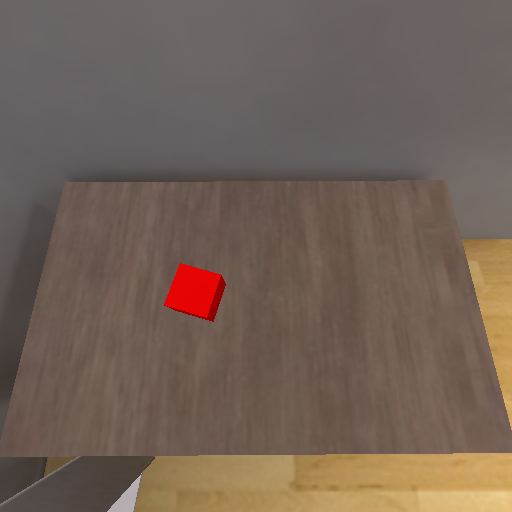

In [132]:
Image.fromarray((frames['top'][0]* 255).astype(np.uint8))

In [116]:
video_name = "circle_top2.mp4"

generate_video(video_name, frames['top'], fps=10, color_change=True)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [117]:
video_show = 'demos/video_show_top3.mp4'
!ffmpeg -y -i {video_name} {video_show} &> /dev/null

Video(video_show) 

In [107]:
video_show = 'demos/video_show.mp4'
!ffmpeg -y -i {video_name} {video_show} &> /dev/null

Video(video_show) 

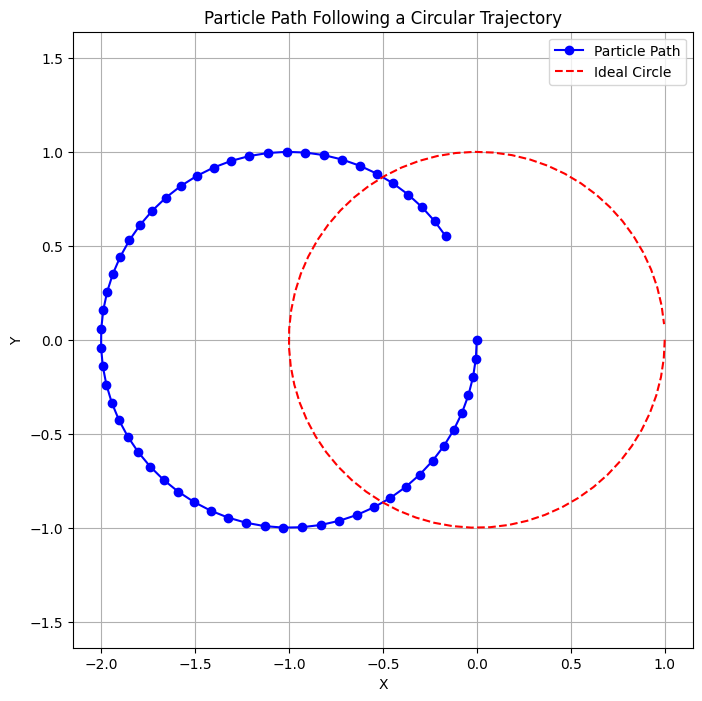

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
r = 1
delta_t = 0.1

### left circle; counter clockwise
t_values = np.arange(0, 2*np.pi, delta_t)
### left circle; clockwise
#t_values = np.arange(0, -2*np.pi, -delta_t)
### right circle; clockwise
#t_values = np.arange(np.pi, -np.pi, -delta_t)
### right circle; counter clockwise
#t_values = np.arange(-np.pi, np.pi, delta_t)


# Positions
x_values = r * np.cos(t_values)
y_values = r * np.sin(t_values)

# Displacements
displacements = []
for i in range(len(t_values) - 1):
    delta_x = x_values[i + 1] - x_values[i]
    delta_y = y_values[i + 1] - y_values[i]
    displacements.append((delta_x, delta_y))

# Initial position
x, y = 0, 0

# Path of the particle
path_x = [x]
path_y = [y]

for dx, dy in displacements[:-5]:
    x += dx
    y += dy
    path_x.append(x)
    path_y.append(y)

# Plot the path
plt.figure(figsize=(8, 8))
plt.plot(path_x, path_y, 'bo-', label='Particle Path')
plt.plot(x_values, y_values, 'r--', label='Ideal Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Path Following a Circular Trajectory')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

### Speed

In [14]:
from itertools import product
from itertools import combinations
data_dir = "benchmark/speed"

flush = True
if flush:
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
        os.makedirs(data_dir)

# initialize pair of trajectories (The last one is random)
# initialize pair of colors
random.seed(42)
objects = ["cube","sphere","custom"]
object_pairs = list(combinations(objects, 2))
obj_num = 2
moving_directions = [["left"],["right"],["front"],["behind"]]
strings = color_maps.keys()
color_pairs = list(itertools.permutations(strings, obj_num))[:7]
random.shuffle(color_pairs)
direction_lengths  = [0.2,0.3,0.4]
potential_sizes = [0.03, 0.05]
scales = [1.1,1.4]
ranges =[(-0.2, 0.2), (-0.2, 0.2)] #[(0.0, 0.02), (-0.2, -0.19)]
configs = []

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    # loop through two speed
    for objects in object_pairs:
        for colors_pair in color_pairs:
            for size in potential_sizes:
                for k,directions in enumerate(moving_directions):
                    info = f"moving_{directions[0]}_{colors_pair[0]}{objects[0]}_ref_{colors_pair[1]}{objects[1]}_size_{size}"
                    for distance in direction_lengths:
                        configs = []
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            env = gym.make("CustomEnv-v0", obs_mode="rgbd")
                        for obj_index, obj_type in enumerate(objects):
                            #cube1_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_1], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
                            #cube2_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_2], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
                   
                            color = colors_pair[obj_index]
                            if(obj_type == 'custom'):
                                obj_config = {'size': size, 'color': color_maps[color], 'obj_type': obj_type, 'name': "002_master_chef_can", 'size': size*1.1/2, 'ranges': ranges, 'static': True}
                            else:
                                obj_config = {'size': size, 'color': color_maps[color], 'obj_type': obj_type, 'ranges': ranges, 'static': True, "name":obj_type}
                            #random_ball_configs = [{'size': np.random.uniform(0.01, 0.05, 1)[0], 'color': color_maps["purple"], 'obj_type': "sphere", 'ranges': [(-0.5, 0.3), (-0.5, 0.4)]} for _ in range(5)]
                            configs += [obj_config] #+ random_ball_configs
                            #configs = [custom_config]
            
                        configs_collate = collate_infos(configs)
                        env.register_configures(configs_collate)
                        _ = env.reset(options={"reconfigure": True})

                        env.initialize_objects()
                        obs, _, _, _, _ = env.step(np.zeros(len(env.action_space.sample())))

                        initilization_poses = env.get_important_obj_poses(mode="all")

                        ###Intializing for each direction given the same intialized positions above
                        env.set_poses(initilization_poses)
                        direction_configs = [(0, 0, direction) for direction in directions]
                        distances = [distance for _ in directions]
                        frames = env.move_in_directions(direction_configs, distances, steps=None, camera_view="all")
                        video_name = f"distance_{distance}"
                        video_path = os.path.join(data_dir, f"{info}/videos/{video_name}.mp4")
                        os.makedirs(os.path.dirname(video_path), exist_ok=True)
                        generate_video(video_path, frames['top0'], fps=20, color_change=True)


                        image_dir = os.path.join(data_dir, f"{info}/distance_{distance}_pics")

                        save_images_pararell(frames['top0'], image_dir)
                    
                        #write_out(f"{data_dir}/index.jsonl", outputs)
            
                

                        del env

2024-08-06 13:13:00,307 - mani_skill2 - WARNING - Override registered env CustomEnv-v0
[2024-08-06 13:13:00.407] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-06 13:13:00.412] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:13:00.412] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-06 13:13:00.412] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb


[2024-08-06 13:13:01.435] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-06 13:13:01.440] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:13:01.440] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-06 13:13:01.440] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:13:02.530] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:13:02.530] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-06 13:13:02.530] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
[2024-08-06 13:

KeyboardInterrupt: 

### distance

In [26]:
from agent_env_utils import *
import math
data_dir = "benchmark/direction"

objects = ["cube","sphere","cube","sphere",'cube',"cube"]
obj_num = len(objects)

flush = True
if flush:
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
        os.makedirs(data_dir)

# initialize pair of trajectories (The last one is random)
moving_directions = [["front"],["behind"], ["left"],["right"],["left_behind"],["left_front"],["right_front"],["right_behind"]]
# initialize pair of colors
strings = color_maps.keys()
pairs = list(itertools.permutations(strings, obj_num))
random.seed(42)
random.shuffle(pairs)
colors = pairs[0]
potential_sizes = [0.03, 0.035]
direction_length  = 0.2
scales = [1.1,1.4]
ranges =[(-0.4, 0.4), (-0.4, 0.3)] #[(0.0, 0.02), (-0.2, -0.19)]
configs = []
speeds = [5,10]



import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    # loop through two speed
    for obj_index, obj_type in enumerate(objects):                                           
        #cube1_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_1], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
        #cube2_config = {'size': np.random.uniform(0.05, 0.08, 1)[0], 'color': color_maps[color_2], 'obj_type': "cube", 'ranges': [(-0.3, 0.3), (-0.3, 0.25)]}
        size = random.choice(potential_sizes)
        color = colors[obj_index]
        ranges = [(-0.2, 0.2), (-0.15, 0.15)] if obj_index == 1 else [(-0.4, 0.4), (-0.4, 0.3)]
        if(obj_type == 'custom'):
            obj_config = {'obj_type': obj_type, 'name': "002_master_chef_can", 'size': size*1.1/2, 'ranges': ranges, 'static': True}
        else:
            obj_config = {'size': size, 'color': color_maps[color], 'obj_type': obj_type, 'ranges': ranges, 'static': True}
            #random_ball_configs = [{'size': np.random.uniform(0.01, 0.05, 1)[0], 'color': color_maps["purple"], 'obj_type': "sphere", 'ranges': [(-0.5, 0.3), (-0.5, 0.4)]} for _ in range(5)]

        configs += [obj_config] #+ random_ball_configs
        #configs = [custom_config]
            
    for k,directions in enumerate(moving_directions):
        direction = directions[0]
        #get the obj's initialize position without blocking the path, get moving obj and ref obj position
        env, initilization_poses, mov_pos = initialize_obj_nooverlap_path(direction, configs, direction_length, env)
        initilization_poses[0] = mov_pos 
        env.set_poses(initilization_poses)
        direction_configs = [(0, 0, direction) for direction in directions]
        distances = [direction_length for _ in directions]
        frames = env.move_in_directions(direction_configs, distances, steps=None, camera_view="all")
        video_name = f"traj{k}_{objects[0]}_{colors[0]}"
        video_path = os.path.join(data_dir, f"videos/{video_name}.mp4")
        os.makedirs(os.path.dirname(video_path), exist_ok=True)
        generate_video(video_path, frames['top0'], fps=10, color_change=True)


        image_dir = os.path.join(data_dir, f"traj{k}_move_{colors[0]}{objects[0]}_ref_{colors[1]}{objects[1]}")

        save_images_pararell(frames['top0'], image_dir)
                    
    #write_out(f"{data_dir}/index.jsonl", outputs)
            
                

del env

2024-08-06 13:26:21,796 - mani_skill2 - WARNING - Override registered env CustomEnv-v0


[2024-08-06 13:26:22.300] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.
[2024-08-06 13:26:22.307] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:26:22.307] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-06 13:26:22.307] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:26:23.470] [SAPIEN] [error] File not found: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
[2024-08-06 13:26:23.470] [SAPIEN] [error] Failed to load non-convex mesh for actor
[2024-08-06 13:26:23.470] [SAPIEN] [error] Failed to load visual mesh: data/hab2_bench_assets/stages/Baked_sc1_staging_00.glb
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
[2024-08-06 13:

### Visual Attribute

#### Color

In [4]:
def generate_object(env, obj_infos, save_info):
    outputs = []
    configs = []
    episode_id = save_info['episode_id']
    final_dir = save_info['output_dir']

    obj_names = obj_infos['obj_name']
    size_settings = obj_infos['size_settings']
    initiate_area = obj_infos['initiate_area']
    bound_directions = obj_infos['bound_direction']
    static = obj_infos['static']
    if("top" in bound_directions):
        static = True
    sizes = [round(np.random.uniform(num*0.02, num*0.02+0.01, 1).tolist()[0], 5) for num in size_settings ]
    colors = obj_infos['color']
    color_ids = [color_maps[color] for color in colors]
    base_size =  0.08

    ### Create configurations (Obj_id example: 026_sponge)
    bounds = []
    for i, obj_name in enumerate(obj_names):
        obj_type = obj_name.split("-")[0]
        obj_id = obj_name.split("-")[-1]
        if(obj_type == "custom"):
            actual_size = sizes[i]*1.1/2
        else:
            actual_size = sizes[i]

        if(obj_id == "bound"):
            bounds.append(i)

        configs.append({'obj_type': obj_type, 'name': obj_id, 'size': actual_size, 'color': color_ids[i], 
                        'ranges': initiate_area, 'static': static})

    ### Extra configs for bounding objects
    extra_configs = []
    for bound_id in bounds:
        for i in range(7):
            extra_configs.append(configs[bound_id].copy())
    # extra_configs = [configs[0].copy() for _ in range(8)]
    # configs += extra_configs

    env.register_configures(collate_infos(configs))
    if(len(extra_configs) != 0):
        env.register_configures(collate_infos(extra_configs), replace=False)
    _ = env.reset(options={"reconfigure": True})

    env.initialize_objects(regular=True)
    
    main_placements = []
    for i, obj_config in enumerate(configs):
        if(i+1 >= len(configs)):
            break
        main_placements.append((i+1, i, "right")) #, (1, 0, "top"), (1, 0, "front")]

    
    distances = [np.random.uniform(3*base_size, 3.5*base_size, size=1)[0] * np.sqrt(2)]

    for direction_config in main_placements:
        if(direction_config[2] == "top" and obj_type == "custom"):
            env.place_cubes_in_direction(direction_config, distances=distances+2*base_size,)
        else:
            env.place_cubes_in_direction(direction_config, distances=distances)
        
    ### Prepare bounded areas
    for k,bound_id in enumerate(bounds):
        ### Border
        id_offset = k*7 + len(configs)
        if(bound_directions[k] == "front"):
            bound_direction_configs = [(0+id_offset, bound_id, "left"), (bound_id, bound_id, "right"), 
                                    (1+id_offset, 0+id_offset, "behind"), (2+id_offset, 1+id_offset, "right"), (3+id_offset, 2+id_offset, "right"),
                                        (4+id_offset, 0+id_offset, "front"), (5+id_offset, 4+id_offset, "right"), (6+id_offset, 5+id_offset, "right"),]
            env.place_cubes_in_direction(bound_direction_configs, distances=[2*configs[bound_id]['size'] for _ in bound_direction_configs])
            
        elif(bound_directions[k] == "top"):
            bound_direction_configs = [ (0+id_offset, bound_id, "left"), (1+id_offset, bound_id, "right"),
                                     (2+id_offset, 0+id_offset, "top"), (3+id_offset, 1+id_offset, "top"),
                                        (4+id_offset, 2+id_offset, "top"), (5+id_offset, 3+id_offset, "top"), (6+id_offset, 5+id_offset, "left"),]
            dist_list = [2.5*configs[bound_id]['size'] if cfg[2] == "top" else 2*configs[bound_id]['size'] for cfg in bound_direction_configs]
            env.place_cubes_in_direction(bound_direction_configs, distances=dist_list)
        
    save_dir_initial = f"{final_dir}/object{episode_id}.png"
    collect_and_save(env, save_dir_initial, steps=5, mode="all")


    outputs.append({
        "source": save_dir_initial,
        "obj_names": obj_names,
        'sizes': sizes,
        "colors": colors,
        "initiate_area": initiate_area,
        "bound_directions": bound_directions,
    })
    return outputs



In [5]:
data_dir = "benchmark/visual_attr/color_two"
initial_dir = f"{data_dir}/initial"
final_dir = f"{data_dir}/final"
os.makedirs(initial_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)

flush = True
if flush:
    if os.path.exists(final_dir):
        shutil.rmtree(final_dir)
        os.makedirs(final_dir)
    if os.path.exists(os.path.join(data_dir, "index.jsonl")):
        os.remove(os.path.join(data_dir, "index.jsonl"))

num_objects = 2
# initialize pair of colors
color_keys = color_maps.keys()
pairs = list(itertools.permutations(color_keys, num_objects))
random.seed(42)
random.shuffle(pairs)
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    env = gym.make("CustomEnv-v0", obs_mode="rgbd")

    outputs = []
    size_types = [1,2,3]
    initiate_areas = [[(0.15, 0.25), (-0.5, -0.4)], [(-0.25, -0.15), (-0.5, -0.4)], [(0.15, 0.25), (0.1, 0.2)], [(-0.25, -0.15), (0.1, 0.2)]] #left-down, left-top, right-down, right-top
    space_types = ["cube-bound", "cube", "sphere", "sphere-bound"]
    # 72 color pairs
    idx = 0
    #Here "front" is same as "side" since the bounding is square
    bound_types = ["front", "top"]
    for size_settings in list(itertools.permutations(size_types, num_objects)):
        #irelevant variables
        for obj_names in list(itertools.permutations(space_types, num_objects)):  # "custom-002_master_chef_can"]
            for initiate_area in initiate_areas:
                num_bound_cases = sum([1 if "bound" in obj else 0 for obj in obj_names])
                for bound_directions in list(itertools.product(bound_types, repeat=num_bound_cases)):
                    for colors in pairs[0:10]+[[color]*num_objects for color in color_keys]:
                        obj_infos={
                            'obj_name': obj_names,
                            'size_settings': size_settings,
                            'color': colors,
                            'initiate_area': initiate_area,
                            'bound_direction': bound_directions,
                            'static': True}
                        
                        save_infos={
                                'episode_id': idx,
                                'output_dir': final_dir,
                                }
                        outputs += generate_object(env, obj_infos, save_infos)
                        idx += 1 
                
    write_out(f"{data_dir}/index.jsonl", outputs)
            
                

del env

[2024-07-10 19:56:34.960] [svulkan2] [error] GLFW error: X11: Failed to open display :1
[2024-07-10 19:56:34.960] [svulkan2] [warning] Continue without GLFW.


### Previous

In [11]:
potential_size = 0.05
direction_length  = 0.2
scales = [1.1,1.4]
ranges =[(0, 0),(0.6,0.6) ]
env = gym.make("CustomEnv-v0", obs_mode="rgbd")
color_maps = {"red": (1, 0, 0), "blue": (0, 0, 1), "purple": (0.5, 0, 0.5),}
obj_type = 'cube'
obj_config = {'size': potential_size, 'color': color_maps['purple'], 'obj_type': obj_type, 'ranges': ranges, 'static': True}


#random_ball_configs = [{'size': np.random.uniform(0.01, 0.05, 1)[0], 'color': color_maps["purple"], 'obj_type': "sphere", 'ranges': [(-0.5, 0.3), (-0.5, 0.4)]} for _ in range(5)]

configs = [obj_config] #+ random_ball_configs
#configs = [custom_config]

configs_collate = collate_infos(configs)
env.register_configures(configs_collate)

_ = env.reset(options={"reconfigure": True})
env.initialize_objects(background=2)
returned = env.step(np.zeros(len(env.action_space.sample())))

[2024-07-25 14:28:30.720] [svulkan2] [warning] A second renderer will share the same internal context with the first one. Arguments passed to constructor will be ignored.


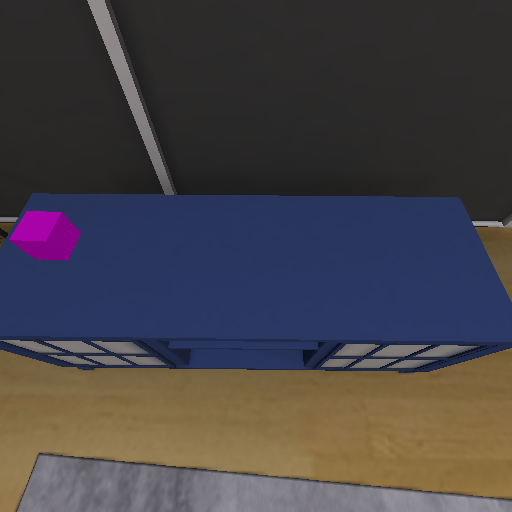

In [12]:
Image.fromarray(returned[0]['image']['top2']['rgb'])

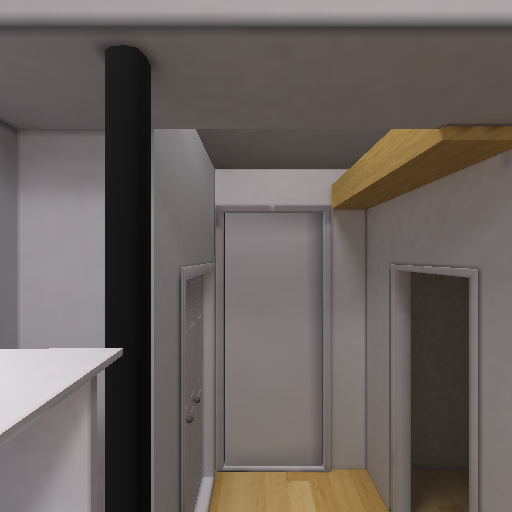

In [28]:
Image.fromarray(returned[0]['image']['search3']['rgb'])